In [14]:
using TestImages, Images, ImageView


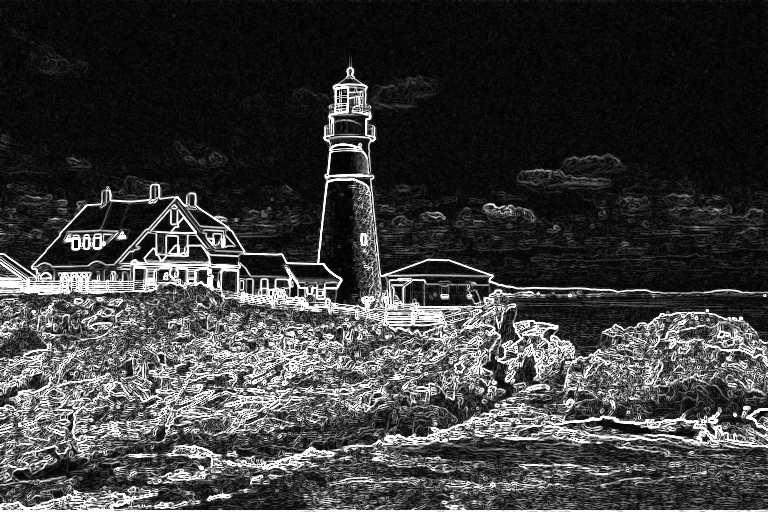

In [15]:
img=testimage("lighthouse")
gray=convert(Image{Images.Gray}, img)
Gx_, Gy_=imgradients(gray, "sobel")
energy=sqrt(Gx_.^2+Gy_.^2)

In [16]:
function cumulative_minimum_energy_map(energy)
    (height, width)=size(energy)
    cumulativeEnergyMap=energy
    for j=2:width
            for i=1:height
                if i==1
                    cumulativeEnergyMap[i,j]=cumulativeEnergyMap[i,j]+min(cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i+1, j-1])
                elseif i==height
                    cumulativeEnergyMap[i,j]=cumulativeEnergyMap[i,j]+min(cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i-1, j-1])
                else
                    cumulativeEnergyMap[i,j]=cumulativeEnergyMap[i,j]+min(cumulativeEnergyMap[i-1,j-1], cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i+1, j-1])
                end
            end
    end
    return cumulativeEnergyMap
end

cumulative_minimum_energy_map (generic function with 1 method)

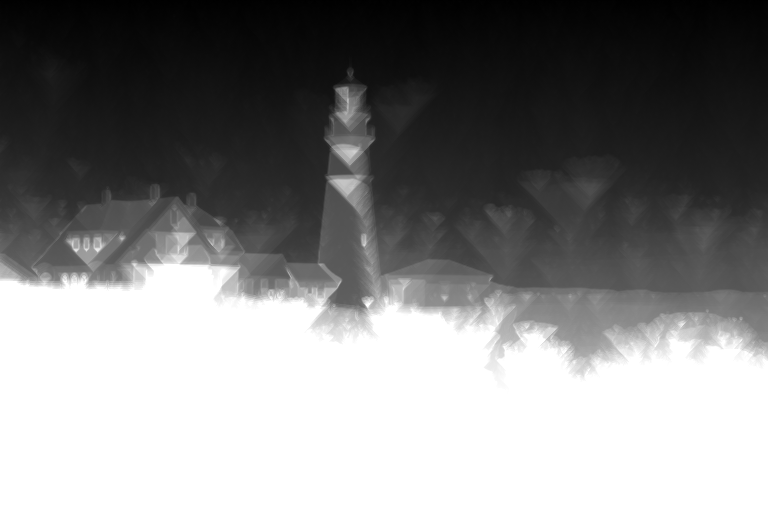

In [17]:
cumulativeEnergyMap = cumulative_minimum_energy_map(energy)
cumulativeEnergyMap*0.05


In [9]:
a, index=findmin([100,2,4])
i=100
j=100
b, indx=min(cumulativeEnergyMap[i,j-1], cumulativeEnergyMap[i+1, j-1])
indx

LoadError: BoundsError

In [22]:
function find_optimal_horizontal_seam(cumulativeEnergyMap)
    (height,width)=size(cumulativeEnergyMap)
    yLocation=width
    horizontalSeam=Array{Int32,1}(width)
    minVal, xLocation=findmin(cumulativeEnergyMap[:,width])
    i=xLocation
    for j=width:-1:2
        horizontalSeam[j]=i
        if i==1
            minVal,relative_i=findmin([cumulativeEnergyMap[i,j-1], cumulativeEnergyMap[i+1, j-1]])
            i=i+relative_i-1
        elseif i==width
            minVal, relative_i=findmin([cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i-1,j-1]])
            i=i-relative_i+1
        else
            minVal, relative_i=findmin([cumulativeEnergyMap[i-1,j-1], cumulativeEnergyMap[i, j-1], cumulativeEnergyMap[i+1, j-1]])
            i=i+relative_i-2
        end
    end
    horizontalSeam[1]=i
    return horizontalSeam
end

find_optimal_horizontal_seam (generic function with 1 method)

In [23]:
horizontalSeam = find_optimal_horizontal_seam(cumulativeEnergyMap)

512-element Array{Int32,1}:
 639
 639
 640
 640
 640
 640
 640
 640
 640
 641
 641
 642
 642
   ⋮
 621
 620
 619
 618
 619
 620
 621
 620
 619
 619
 620
 621

In [24]:
function display_seam(im,seam)
    (height, width)=size(im)
    for seamIdx in 1:length(seam)
        im[seam[seamIdx],seamIdx] = 30/255
    end
end

display_seam(gray,horizontalSeam)

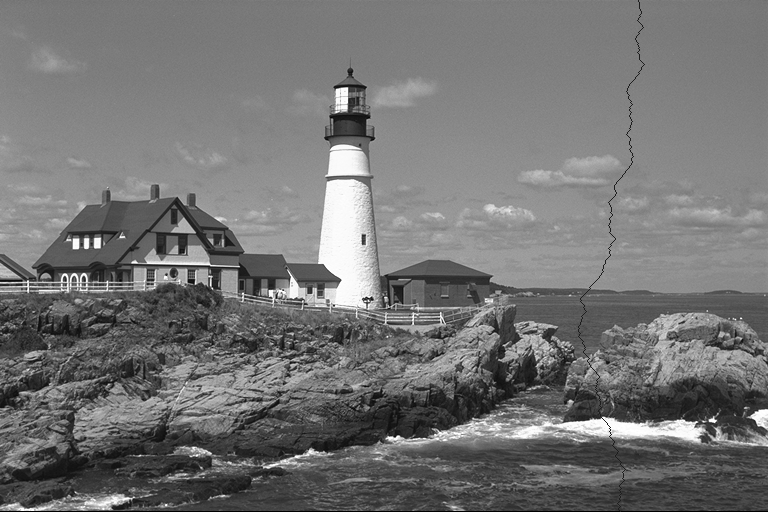

In [26]:
gray


In [28]:
1:(4)

1:4

In [105]:
function reduce_height(im,energyImage)
    (height, width)=size(im)
    cumulativeEnergyMap = cumulative_minimum_energy_map(energyImage)
    horizontalSeam = find_optimal_horizontal_seam(cumulativeEnergyMap)
    #display_seam(im, horizontalSeam)
    reducedColorImage = uint8(rand(height-1, width,3))
    reducedEnergyImage = Array{Float64,2}(height-1,width)
    for j=1:width
        reducedColorImage[1:(horizontalSeam[j]-1),j]=im[1:(horizontalSeam[j]-1),j]
        reducedColorImage[horizontalSeam[j]:(height-1),j]=im[(horizontalSeam[j]+1):height,j]
        reducedEnergyImage[1:(horizontalSeam[j]-1),j]=energyImage[1:(horizontalSeam[j]-1),j]
        reducedEnergyImage[horizontalSeam[j]:(height-1),j]=energyImage[(horizontalSeam[j]+1):height,j]
    end
    return reducedColorImage,reducedEnergyImage
            
end



reduce_height (generic function with 1 method)

In [106]:
reduce_height(img,energy)
#typeof(img)

 in depwarn at ./deprecated.jl:73
while loading In[106], in expression starting on line 1


LoadError: MethodError: `convert` has no method matching convert(::Type{UInt8}, ::ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}})
This may have arisen from a call to the constructor UInt8(...),
since type constructors fall back to convert methods.[0m
Closest candidates are:
  call{T}(::Type{T}, ::Any)
  convert(::Type{UInt8}, [1m[31m::Int8[0m)
  convert(::Type{UInt8}, [1m[31m::Int16[0m)
  ...[0m

In [ ]:
function Multiple_seam_carving_reduce_height(n, im, energy)
    if n==0
        reducedIm=im;
        reducedEnergy=energy;
    else
        (im_2, energy_2)=reduce_height(im, energy);
        n=n-1;
        [reducedIm, reducedEnergy]=Multiple_seam_carving_reduce_height(n, im_2, energy_2);
    end
end